## Data preparation

In [1]:
%pylab inline

import math
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns


# Constants for graph sizes

INCH_TO_CM = 1./2.54
GRID_WIDTH = 2*(17.6 / 3) * INCH_TO_CM
GRID_HEIGHT = 2 * 4.4 * INCH_TO_CM
GRID_SIZE = (GRID_WIDTH, GRID_HEIGHT)


mpl.rc("figure", figsize=GRID_SIZE)
sns.set_context("paper", font_scale=1.6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
%run scripts/definitions.py
%run scripts/files.py
%run scripts/file_data.py

In [3]:
datas = [FileData(x) for x in FILES]
df = generate_df_and_write_csv(datas, "results.csv")

df['Adaption Ratio'] = df['Adaption Ratio'].map(lambda x: x.magnitude)

Processing ../../Papers/001 Costim letter/Data\45_Data 082.axgd which has 33 runs
Processing ../../Papers/001 Costim letter/Data\45_Data 083.axgd which has 30 runs
Processing ../../Papers/001 Costim letter/Data\45_Data 084.axgd which has 30 runs
Processing ../../Papers/001 Costim letter/Data\45_Data 085.axgd which has 30 runs
Processing ../../Papers/001 Costim letter/Data\45_Data 086.axgd which has 30 runs
Processing ../../Papers/001 Costim letter/Data\45_Data 087.axgd which has 30 runs
Processing ../../Papers/001 Costim letter/Data\45_Data 088.axgd which has 30 runs
Processing ../../Papers/001 Costim letter/Data\45_Data 089.axgd which has 30 runs
Processing ../../Papers/001 Costim letter/Data\50_Data 014.axgd which has 30 runs
Processing ../../Papers/001 Costim letter/Data\50_Data 015.axgd which has 30 runs
Processing ../../Papers/001 Costim letter/Data\50_Data 016.axgd which has 30 runs
Processing ../../Papers/001 Costim letter/Data\50_Data 017.axgd which has 30 runs
Processing ../..

D:\Tools\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Tools\Anaconda\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [4]:
def get_optical(x):
    if x == 0: return "OFF"
#     elif x < 50: return "< 50%"
    elif x < 100: return "O (< 100%) + E"
    return "O (≥ 100%) + E"

df['Laser Power'] = df['Optical Power'].map(get_optical)
df['Electrical Stimulus'] = (100 * df['Electrical Power'] / df['Electrical Threshold']).map(lambda x: math.floor(x))

df['Optical Bucket'] = df['Optical Power'].map(lambda x: round(x / 10) * 10)
df['Electrical Bucket'] = df['Electrical Stimulus'].map(lambda x: round(x / 5) * 5)
df.tail()

,index,Run,Optical Power,Spikes,Electrical Power,Electrical Threshold,Vector Strength,Vector Strength Phase,Adaption Ratio,Spike Ratio,Frequency,Cell,Laser Power,Electrical Stimulus,Optical Bucket,Electrical Bucket
2410,25,../../Papers/001 Costim letter/Data\55_Data 05...,109,6,150,150,0.999828,0.184792,0.733027,60.0,50,5507,O (≥ 100%) + E,100,110,100
2411,26,../../Papers/001 Costim letter/Data\55_Data 05...,109,10,165,150,0.999836,0.187798,0.770526,100.0,50,5507,O (≥ 100%) + E,110,110,110
2412,27,../../Papers/001 Costim letter/Data\55_Data 05...,109,10,180,150,0.999837,0.187562,0.801414,100.0,50,5507,O (≥ 100%) + E,120,110,120
2413,28,../../Papers/001 Costim letter/Data\55_Data 05...,109,10,195,150,0.999836,0.187478,0.795744,100.0,50,5507,O (≥ 100%) + E,130,110,130
2414,29,../../Papers/001 Costim letter/Data\55_Data 05...,109,10,210,150,0.999837,0.187400,0.803408,100.0,50,5507,O (≥ 100%) + E,140,110,140


## Pulse train examples

In [5]:
def do_plots(file_idxs, runs, end_idx, axs):
    """Does the actual plot"""
    for i, (idx, run) in enumerate(zip(file_idxs, runs)):
        datas[idx].plot_run(run, end_idx=end_idx, include_peaks=True, o_bucket=10, ax=axs[i], color='k')
        
    for i in range(len(axs)):
        if i == 0:
            axs[i].set_ylabel("Membrane\nVoltage (mV)")
        else:
            axs[i].set_ylabel("")

def plot_pulse_trains(file_idxs, runs, end_idx, save_file_path):
    """Shortcut for plotting"""
    fig, axs = plt.subplots(1, 4, figsize=(2 * GRID_WIDTH, GRID_HEIGHT), sharex=True, sharey=True)

    do_plots(file_idxs, runs, end_idx, axs)

    plt.tight_layout()
    plt.show()

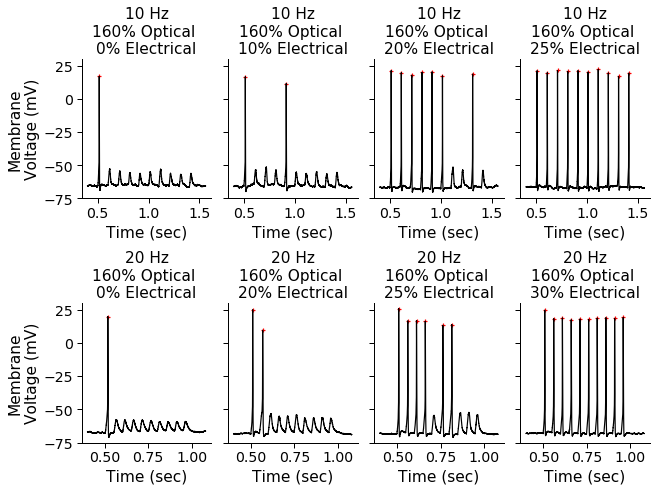

In [6]:
fig, (row1, row2) = plt.subplots(2, 4, figsize=(2 * GRID_WIDTH, 2 * GRID_HEIGHT), sharey=True)
do_plots([1] * 4, [1, 3, 5, 7], 78000, row1)
do_plots([2] * 4, [1, 6, 7, 8], 54000, row2)
plt.tight_layout()
plt.show()

## Firing likelihood

In [7]:
palette = [ "#888888", "#222222", "#FF0000", "#0000FF" ]
markers = ['x', 'o', 'v', ]

def plot_activation_curves(df, freq, delta=10, max_e=140, legendon=False, aspect=2, height=GRID_HEIGHT):
    fontsize=28
    
    this_df = df[
        ((df['Electrical Bucket'] >= 0) & (df['Electrical Bucket'] <= max_e)) &
        (df['Electrical Bucket'] % delta == 0) #&
#         ((df['Optical Bucket'] == 0) | (df['Optical Bucket'] >= 100) | (df['Optical Bucket'] < 100))
    ].copy()
        
    this_df['Firing probability\n(APs per pulse)'] = this_df['Spike Ratio'] / 100.
    cell_set = set(this_df['Cell'])
    print(f"Cell IDs (n={len(cell_set)}): {cell_set}")

    palette = [ "#888888", "#222222", "#FF0000", "#0000FF" ]
    
    g = sns.catplot(
        x='Electrical Bucket', y='Firing probability\n(APs per pulse)', hue='Laser Power', row='Frequency',
        data=this_df,
        ci=68, # this should get the SEM
        markers=markers, scale=2,
        height=1.5*height, kind='point', aspect=aspect, legend_out=False, legend=False, lw=1, palette=palette)
    
    for nax in g.fig.axes:
        nax.set_title(nax.get_title().replace('Frequency = ', '') + ' Hz', fontsize=fontsize)
        nax.set_ylabel('Firing probability\n(APs per pulse)', fontsize=fontsize)
        nax.tick_params(labelsize=24)

    if legendon == True:
        l = plt.legend(frameon=False, title='Laser Power', fontsize=fontsize)
        plt.setp(l.get_title(), fontsize=fontsize)

    plt.xlabel('Electrical Power\n(% single pulse threshold)', fontsize=fontsize)
    
    plt.ylim((-0.1, 1.1))
    
    plt.tight_layout()

Cell IDs (n=12): {5506, 5507, 5003, 5006, 5202, 5203, 5205, 5207, 4504, 5208, 5404, 5406}


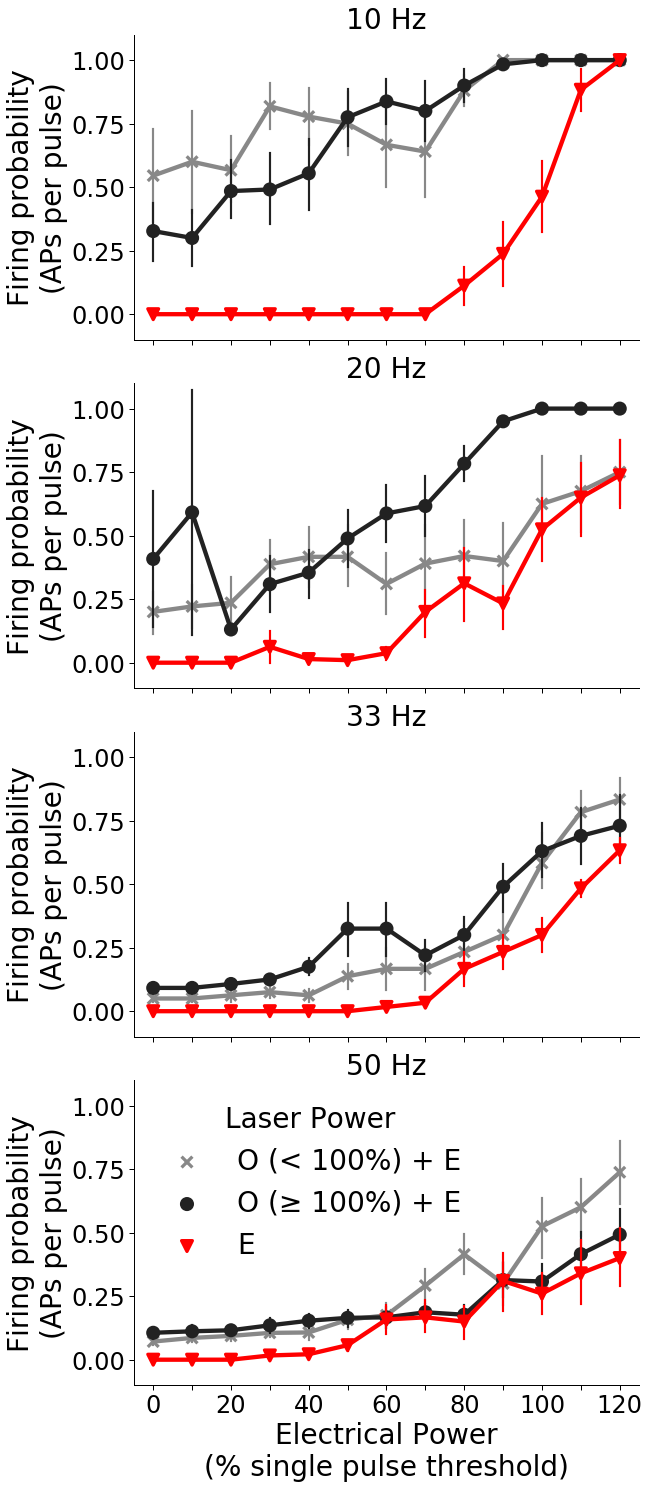

In [8]:
df_slice = df[(
    df['Frequency'] <= 50
)].copy()

# rename OFF to elec only for clarity
df_slice['Laser Power'] = df_slice['Laser Power'].map(lambda p: 'E' if p == 'OFF' else p)

plot_activation_curves(df_slice, "all_", delta=10, max_e=120, aspect=1.75, height=GRID_HEIGHT, legendon=True)
plt.xticks(range(13), [0, '', 20, '', 40, '', 60, '', 80, '', 100, '', 120, ''])
plt.show()

In [9]:
print("*** COMPARISON OF CURVES USING KS_2SAMP ***")

sup_key = 'O (≥ 100%) + E'
sub_key = 'O (< 100%) + E'
ele_key = 'E'

def check_frequency(data, freq):
    print(f" --> {freq}Hz")
    spike_ratios = data[(data['Frequency'] == freq)]\
        .groupby(['Laser Power', 'Electrical Bucket'])\
        .agg(np.mean)['Spike Ratio']\
        .reset_index()\
        .pivot(index='Electrical Bucket', columns='Laser Power', values='Spike Ratio')\
        .dropna()

    print(f"    SUB vs SUP {stats.ks_2samp(spike_ratios[sub_key], spike_ratios[sup_key])}")
    print(f"    SUB vs ELE {stats.ks_2samp(spike_ratios[sub_key], spike_ratios[ele_key])}")
    print(f"    SUP vs ELE {stats.ks_2samp(spike_ratios[sup_key], spike_ratios[ele_key])}\n")

check_frequency(df_slice, 10)
check_frequency(df_slice, 20)
check_frequency(df_slice, 33)
check_frequency(df_slice, 50)

*** COMPARISON OF CURVES USING KS_2SAMP ***
 --> 10Hz
    SUB vs SUP Ks_2sampResult(statistic=0.34615384615384615, pvalue=0.06803045149939686)
    SUB vs ELE Ks_2sampResult(statistic=0.8076923076923077, pvalue=2.0272169862041205e-08)
    SUP vs ELE Ks_2sampResult(statistic=0.576923076923077, pvalue=0.00016687541680884675)

 --> 20Hz
    SUB vs SUP Ks_2sampResult(statistic=0.1923076923076924, pvalue=0.6738309195262766)
    SUB vs ELE Ks_2sampResult(statistic=0.5769230769230769, pvalue=0.0001668754168088476)
    SUP vs ELE Ks_2sampResult(statistic=0.5769230769230769, pvalue=0.0001668754168088476)

 --> 33Hz
    SUB vs SUP Ks_2sampResult(statistic=0.3333333333333333, pvalue=0.3079352891587556)
    SUB vs ELE Ks_2sampResult(statistic=0.5333333333333333, pvalue=0.016786481071967625)
    SUP vs ELE Ks_2sampResult(statistic=0.5333333333333333, pvalue=0.016786481071967625)

 --> 50Hz
    SUB vs SUP Ks_2sampResult(statistic=0.16000000000000003, pvalue=0.8774132527980119)
    SUB vs ELE Ks_2samp

## Adaption ratios

In [10]:
print("Adaption across all electrical powers:")
df2 = df[(df.Spikes > 5)]

print(f"There are {len(df2['Cell'].unique())} cells")

df3 = df2.groupby(['Frequency', 'Electrical Bucket']).agg(np.mean).reset_index() \
    .groupby(['Frequency'])['Adaption Ratio', 'Vector Strength'].agg([np.mean, stats.sem])

df3

Adaption across all electrical powers:
There are 12 cells


D:\Tools\Anaconda\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
D:\Tools\Anaconda\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Adaption Ratio           Vector Strength              
                    mean       sem            mean           sem
Frequency                                                       
10              0.944725  0.002875        0.999839  6.401223e-07
20              0.904541  0.047923        0.999798  2.980518e-05
33              0.827130  0.007604        0.999832  7.152311e-06
50              0.717731  0.012068        0.999830  4.723610e-06
66              0.690092       NaN        0.999792           NaN

In [11]:
print("Adaption @ 50Hz electrical only")

df2 = df[
    (df.Frequency == 50) &
    (df['Optical Bucket'] == 0) &
    (df.Spikes > 5)
]

print(f"There are {len(df2['Cell'].unique())} cells")

elec_tt = list(df2['Adaption Ratio'])

df2.groupby(['Frequency', 'Electrical Bucket']).agg(np.mean).reset_index() \
    .groupby(['Frequency'])['Adaption Ratio', 'Vector Strength'].agg([np.mean, stats.sem])

Adaption @ 50Hz electrical only
There are 5 cells


Adaption Ratio           Vector Strength          
                    mean       sem            mean       sem
Frequency                                                   
50              0.775934  0.012469        0.999821  0.000004

In [12]:
print("Adaption costimulation only @ 50Hz:")
df2 = df[
    (df.Frequency == 50) & 
    (df['Optical Bucket'] > 0) & 
    (df['Electrical Bucket'] > 0) &
    (df.Spikes > 5)
]

print(f"There are {len(df2['Cell'].unique())} cells")

costim_tt = list(df2['Adaption Ratio'])

df2.groupby(['Frequency', 'Electrical Bucket']).agg(np.mean).reset_index() \
    .groupby(['Frequency'])['Adaption Ratio', 'Vector Strength'].agg([np.mean, stats.sem])

Adaption costimulation only @ 50Hz:
There are 5 cells


Adaption Ratio           Vector Strength          
                    mean       sem            mean       sem
Frequency                                                   
50              0.736305  0.030009        0.999829  0.000011

In [13]:
print("Comparison of electrical and costim adaption ratios at 50Hz")
stats.ttest_ind(elec_tt, costim_tt)

Comparison of electrical and costim adaption ratios at 50Hz


Ttest_indResult(statistic=0.6909363573921943, pvalue=0.4914241232830675)

## Optical power required to achieve 50% firing at different frequencies

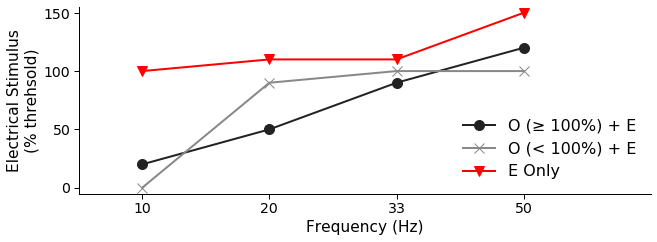

In [14]:
# These values are manually read from the graphs above

fs = ["10", "20", "33", "50"]
l_sup = [20, 50, 90, 120]
l_sub = [0, 90, 100, 100]
l_off = [100, 110, 110, 150]

fig_w = 10
fig, ax = plt.subplots(1, 1, figsize=(2 * GRID_WIDTH, GRID_HEIGHT))

ax.plot(fs, l_sup, marker='o', markersize=10, color=palette[1], label="O (≥ 100%) + E", lw=2)
ax.plot(fs, l_sub, marker='x', markersize=10, color=palette[0], label="O (< 100%) + E", lw=2)
ax.plot(fs, l_off, marker='v', markersize=10, color=palette[2], label="E Only", lw=2)

sns.despine()
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Electrical Stimulus\n(% threhsold)")
l = ax.legend(frameon=False, fontsize ='16')
plt.setp(l.get_title(), fontsize=16)

plt.xlim((-0.5, 4))
plt.ylim((-5, 155))
plt.tight_layout()
plt.show()